In [1]:
import pandas as pd
import numpy as np
import sys

version = ".".join(map(str, sys.version_info[:3]))
print('python version ', version)
print('numpy version ', np.__version__)
print('pandas version ',pd.__version__)

python version  3.6.2
numpy version  1.13.1
pandas version  0.20.3


In [2]:
import geopandas as gpd
import pysal

print("geopandas version ", gpd.__version__)

geopandas version  0.3.0


In [3]:
import matplotlib.pyplot as plt

# Tell the kernel that we want the plots to be in this notebook
# and not in an external window
%matplotlib inline

### US State shapefile
We want the US states shapefile to be the bottom layer to help give the view geographic context.  Additional geographic context is given through city names and points.

In [4]:
cb_2015_us_state = '../../data/shapefiles/cb_2015_us_state_20m/cb_2015_us_state_20m.shp'
us_state_df = gpd.read_file(cb_2015_us_state)
us_state_df.head(3)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,48,01779801,0400000US48,48,TX,Texas,00,676634395761,19027462392,"POLYGON ((-106.623445 31.914034, -106.630114 3..."
1,06,01779778,0400000US06,06,CA,California,00,403488955894,20477992907,"(POLYGON ((-118.593969 33.467198, -118.484785 ..."
2,21,01779786,0400000US21,21,KY,Kentucky,00,102266253024,2389483091,"POLYGON ((-89.544434 36.57451, -89.47934599999..."


In [5]:
# Albers coordinate reference system projection
# for projecting continental US polygons and points
target_crs = {'datum':'WGS84', 'no_defs':True,
              'proj':'aea',
              'lat_1':35, 'lat_2':55,
              'lat_0':45, 'lon_0':10}
# Original Census Bureau boundary shapefile CRS
original_crs = us_state_df.crs

### Exclude polygons that are outside of the continental US

In [6]:
fips_states_outside = set(['02','15','72','66',
                       '78','60','69','64',
                       '68','70','74',
                       '81', '84', '86', '87',
                       '89', '71', '76', '95',
                       '79'])

In [7]:
us_cstate_df = us_state_df[np.logical_not(us_state_df['GEOID'].isin(fips_states_outside))]

### US County shapefile
We want the county FIPS unique identifier as well as the centroid in order to plot points that represent ecommerce employees.  We do not need to plot polygons for the actual counties.

In [8]:
cb_2015_us_county = '../../data/shapefiles/cb_2015_us_county_20m/cb_2015_us_county_20m.shp'
us_county_df = gpd.read_file(cb_2015_us_county)
us_county_df.head(3)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,20,175,00485050,0500000US20175,20175,Seward,06,1655865960,2777350,"POLYGON ((-101.067904 37.38777899999999, -100...."
1,28,141,00695791,0500000US28141,28141,Tishomingo,06,1098939230,52359814,"POLYGON ((-88.36353026853919 34.9957467517971,..."
2,36,101,00974148,0500000US36101,36101,Steuben,06,3601566799,34993606,"POLYGON ((-77.72296399999999 42.471216, -77.72..."


In [9]:
# Get county centroids and then project them to Albers CRS
# The projected points will be plotted using the matplotlib scatter function
def getXY(point):
    return point.x, point.y
county_centers = us_county_df['geometry'].centroid
target_crs = {'datum':'WGS84', 'no_defs':True, 'proj':'aea', 'lat_1':35, 'lat_2':55, 'lat_0':45, 'lon_0':10}
angle_rot = 75
center=(-98.5795,39.8283)
county_centers_albers = county_centers.to_crs(target_crs).rotate(angle=angle_rot,
                                                                 origin=center)
x,y = [list(t) for t in zip(*map(getXY, county_centers_albers))]

county_centers_df = pd.DataFrame({'GEOID': us_county_df['GEOID'],
                                  'NAME': us_county_df['NAME'],
                                  'lon': x,
                                  'lat': y,
                                  'geometry': county_centers_albers})
print('county_centers_df rows, cols', county_centers_df.shape)
county_centers_df.head(3)

county_centers_df rows, cols (3220, 5)


,GEOID,NAME,geometry,lat,lon
0,20175,Seward,POINT (-6450689.870011182 -5606907.714936352),-5.606908e+06,-6.450690e+06
1,28141,Tishomingo,POINT (-5307449.339152199 -5835440.824897715),-5.835441e+06,-5.307449e+06
2,36101,Steuben,POINT (-4535164.692944236 -4840218.932238986),-4.840219e+06,-4.535165e+06


### Core Based Statistical Areas shapefile
Two subsets/categories of these statistical areas will be plotted in order to highlight the fact that more people are employed with the ecommerce NAICS in urban areas.

In [10]:
cb_2015_us_cbsa = '../../data/shapefiles/cb_2015_us_cbsa_20m/cb_2015_us_cbsa_20m.shp'
us_cbsa_df = gpd.read_file(cb_2015_us_cbsa)
us_cbsa_df.head(3)

,CSAFP,CBSAFP,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,357,12660,310M200US12660,12660,"Baraboo, WI",M2,2152007753,45296336,"POLYGON ((-90.312404 43.640988, -89.785809 43...."
1,184,10420,310M200US10420,10420,"Akron, OH",M1,2331619578,62018442,"POLYGON ((-81.68698999999999 41.135956, -81.68..."
2,258,26540,310M200US26540,26540,"Huntington, IN",M2,991056505,13133894,"POLYGON ((-85.64384099999999 41.002305, -85.33..."


### County Business Patterns 2015
The County Business Patterns data provides the number of people employed by job type as well as payroll data.  There is noise added to the data to prevent people from being able to identify data for a particular company.  We want to determine the number of people employed in ecommerce ( US Labor department NAICS 454111 )

In [11]:
filename = '../../data/census/CBP/cbp15co.txt'
cbp_county_2015_df = pd.read_csv(filename,
                                 dtype={'FIPSTATE': str,
                                        'FIPSCTY': str})
print('rows, columns ', cbp_county_2015_df.shape)
cbp_county_2015_df.head()

rows, columns  (2126601, 26)


,FIPSTATE,FIPSCTY,NAICS,EMPFLAG,EMP_NF,EMP,QP1_NF,QP1,AP_NF,AP,...,N100_249,N250_499,N500_999,N1000,N1000_1,N1000_2,N1000_3,N1000_4,CENSTATE,CENCTY
0,01,001,------,NaN,G,10454,G,76437,G,321433,...,6,2,1,0,0,0,0,0,63,1
1,01,001,11----,NaN,H,70,H,790,H,3566,...,0,0,0,0,0,0,0,0,63,1
2,01,001,113///,NaN,H,70,H,790,H,3551,...,0,0,0,0,0,0,0,0,63,1
3,01,001,1133//,NaN,H,70,H,790,H,3551,...,0,0,0,0,0,0,0,0,63,1
4,01,001,11331/,NaN,H,70,H,790,H,3551,...,0,0,0,0,0,0,0,0,63,1


#### Add GEOID column to County Business Patterns employment dataframe 
Use this GEOID to join employment data with centroids of county polygons

In [12]:
geoids = [state + county for state, county in zip(cbp_county_2015_df['FIPSTATE'], cbp_county_2015_df['FIPSCTY'])]
cbp_county_2015_df['GEOID'] = geoids

In [13]:
# Select rows that contain the US Labor department code for ecommerce
ecom_df = cbp_county_2015_df[cbp_county_2015_df['NAICS'] == '454111']
ecom_df.shape

(1824, 27)

In [14]:
# Select rows that have greater than zero ecommerce employees
ecom_co_gt0_df = ecom_df[ecom_df.EMP > 0]
ecom_co_gt0_df.shape

(854, 27)

In [15]:
# Remove rows that are outside of the continental US
ecom_co_gt0_df = ecom_co_gt0_df[np.logical_not(ecom_co_gt0_df['FIPSTATE'].isin(fips_states_outside))]
print('ecom_co_gt0_df rows,cols ', ecom_co_gt0_df.shape)
ecom_co_gt0_df.head(3)

ecom_co_gt0_df rows,cols  (848, 27)


,FIPSTATE,FIPSCTY,NAICS,EMPFLAG,EMP_NF,EMP,QP1_NF,QP1,AP_NF,AP,...,N250_499,N500_999,N1000,N1000_1,N1000_2,N1000_3,N1000_4,CENSTATE,CENCTY,GEOID
1346,01,003,454111,NaN,G,139,G,759,H,2904,...,0,0,0,0,0,0,0,63,3,01003
4860,01,015,454111,NaN,J,3,J,15,G,149,...,0,0,0,0,0,0,0,63,15,01015
8958,01,031,454111,NaN,G,8,G,22,H,99,...,0,0,0,0,0,0,0,63,31,01031


### Distribution of Ecommerce employees

In [16]:
# Statistics after dropping county rows
# with zero ecommerce employees
ecom_co_gt0_df.EMP.describe()

count      848.000000
mean       245.204009
std        805.857876
min          1.000000
25%         15.000000
50%         43.500000
75%        147.000000
max      15882.000000
Name: EMP, dtype: float64

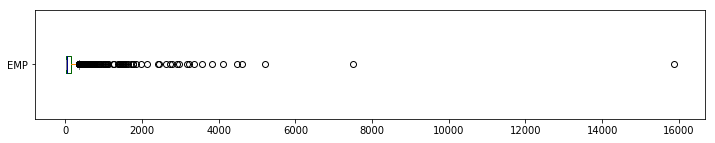

In [17]:
color_def = dict(boxes='DarkGreen', whiskers='DarkOrange',
                 medians='DarkBlue', caps='Gray')
ecom_co_gt0_df['EMP'].plot.box(color=color_def, vert=False, figsize=(12,2))

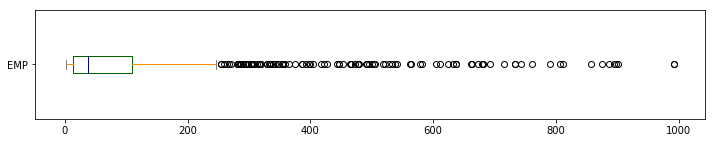

In [18]:
ecom_co_noOutliers = ecom_co_gt0_df[ecom_co_gt0_df.EMP < 1000]
ecom_co_noOutliers.EMP.plot.box(color=color_def, vert=False, figsize=(12,2))

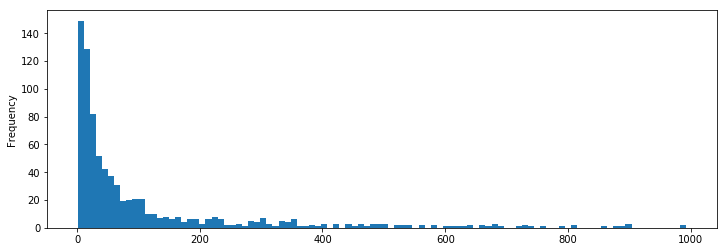

In [19]:
ecom_co_noOutliers = ecom_co_gt0_df[ecom_co_gt0_df.EMP < 1000]
ecom_co_noOutliers.EMP.plot.hist(bins=100, figsize=(12,4))

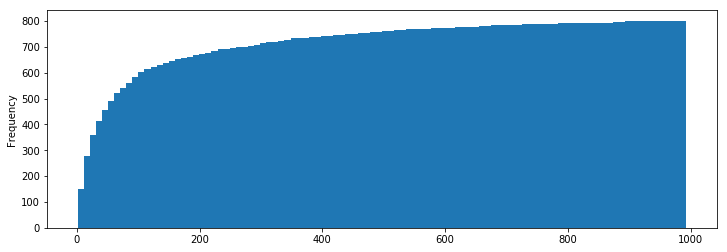

In [20]:
ecom_co_noOutliers = ecom_co_gt0_df[ecom_co_gt0_df.EMP < 1000]
ecom_co_noOutliers.EMP.plot.hist(bins=100, cumulative=True, figsize=(12,4))

### Join ecommerce employment numbers by county with county polygon centroids

In [21]:
left_cols = ['GEOID', 'EMP']
county_ecom_df = ecom_co_gt0_df[left_cols].set_index('GEOID').join(
                                          county_centers_df.set_index('GEOID'),
                                          lsuffix='_e' )
print('county_ecom_df rows,cols', county_ecom_df.shape)
county_ecom_df.head(3)

county_ecom_df rows,cols (848, 5)


,EMP,NAME,geometry,lat,lon
GEOID,,,,,
01003,139,Baldwin,POINT (-5207032.42602911 -6268528.018109216),-6.268528e+06,-5.207032e+06
01015,3,Calhoun,POINT (-5072236.07043945 -5912462.910145535),-5.912463e+06,-5.072236e+06
01031,8,Coffee,POINT (-5050726.247782185 -6173797.708518975),-6.173798e+06,-5.050726e+06


### Population estimates by CBSA
We want to use these population estimates to select polygons for metropolitan areas with more than 1M people as well as metropolitan areas with populations between 250k and 1M

In [22]:
pop_cbsa_2015_df = pd.read_csv('../../data/census/cbsa-est2016-alldata-alt.csv',
                               encoding='latin-1',
                               usecols=['CBSA','NAME','POPESTIMATE2015','RESIDUAL2015'],
                               dtype={'CBSA':str,
                                      'NAME':str,
                                      'POPESTIMATE2015':object,
                                      'RESIDUAL2015':object})
print('pop_cbsa_2015_df rows,cols ', pop_cbsa_2015_df.shape)
pop_cbsa_2015_df.head(3)

pop_cbsa_2015_df rows,cols  (2792, 4)


,CBSA,NAME,POPESTIMATE2015,RESIDUAL2015
0,10180,"Abilene, TX",169893,-13
1,10180,"Callahan County, TX",13596,-9
2,10180,"Jones County, TX",19972,-20


In [23]:
pop_cbsa_2015_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2792 entries, 0 to 2791
Data columns (total 4 columns):
CBSA               2789 non-null object
NAME               2790 non-null object
POPESTIMATE2015    2789 non-null object
RESIDUAL2015       2789 non-null object
dtypes: object(4)
memory usage: 87.3+ KB


In [24]:
pop_cbsa_2015_df.dropna(axis=0, inplace=True)
pop_cbsa_2015_df['CBSA'] = pop_cbsa_2015_df['CBSA'].astype('str')

In [25]:
# Remove CBSA ( CBSA consist of one or more counties ) for Alaska and Hawaii
pop_cbsa_2015_df = pop_cbsa_2015_df[np.logical_not(np.logical_or(pop_cbsa_2015_df['NAME'].str.endswith('AK'),
                                     pop_cbsa_2015_df['NAME'].str.endswith('HI')))]

In [26]:
cbsa_pop_df = us_cbsa_df.set_index('GEOID').join(pop_cbsa_2015_df.set_index('CBSA'),
                                       how='left',
                                       rsuffix='_pop')
print('cbsa_pop_df rows,cols ', cbsa_pop_df.shape)
cbsa_pop_df.head(2)

cbsa_pop_df rows,cols  (2757, 11)


,CSAFP,CBSAFP,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry,NAME_pop,POPESTIMATE2015,RESIDUAL2015
10100,None,10100,310M200US10100,"Aberdeen, SD",M2,7352936358,111452523,"POLYGON ((-99.70770499999999 45.593391, -98.72...","Aberdeen, SD",42708,-20
10100,None,10100,310M200US10100,"Aberdeen, SD",M2,7352936358,111452523,"POLYGON ((-99.70770499999999 45.593391, -98.72...","Brown County, SD",38699,-1


In [27]:
# Number of null values and data types per column
# You can use DataFrame.info() as well
null_df = pd.DataFrame({'number of null values': cbsa_pop_df.isnull().sum(),
                        'data type' : cbsa_pop_df.dtypes})
null_df

,data type,number of null values
CSAFP,object,1052
CBSAFP,object,0
AFFGEOID,object,0
NAME,object,0
LSAD,object,0
ALAND,int64,0
AWATER,int64,0
geometry,object,0
NAME_pop,object,20
POPESTIMATE2015,object,20


In [28]:
# Remove CSAFP column so that we can easily drop the
# population fields that contain Nan values
# These Nan values prevent me from doing a simple select on 
# field POPESTIMATE2015
cbsa_pop_df.drop(labels=['CSAFP',],
                 axis=1,
                 inplace=True)
# Drop the rows that contain Null, Nan
cbsa_pop_df.dropna(axis=0,
                   inplace=True)
cbsa_pop_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2737 entries, 10100 to 49820
Data columns (total 10 columns):
CBSAFP             2737 non-null object
AFFGEOID           2737 non-null object
NAME               2737 non-null object
LSAD               2737 non-null object
ALAND              2737 non-null int64
AWATER             2737 non-null int64
geometry           2737 non-null object
NAME_pop           2737 non-null object
POPESTIMATE2015    2737 non-null object
RESIDUAL2015       2737 non-null object
dtypes: int64(2), object(8)
memory usage: 235.2+ KB


### Create two categories large and medium CBSA

In [29]:
cbsa_pop_df['POPESTIMATE2015'] = cbsa_pop_df['POPESTIMATE2015'].astype('int')
cbsa_pop_large_df = cbsa_pop_df[cbsa_pop_df['POPESTIMATE2015'] > 999999]
cbsa_pop_medium_df = cbsa_pop_df[np.logical_and(cbsa_pop_df['POPESTIMATE2015'] > 250000,
                                 cbsa_pop_df['POPESTIMATE2015'] < 1000000)]

### List of cities and their location


In [30]:
cities_df = pd.read_csv('../../data/cities.csv')
print('cities_df rows,cols ', cities_df.shape)
cities_df.head(3)

cities_df rows,cols  (22, 5)


,name,lon,lat,nx,ny
0,Seattle,-122.3321,47.60621,-1.5,0.0
1,Portland,-122.6765,45.52306,-1.5,0.0
2,Boise,-116.2146,43.61871,1.2,-0.5


### Add GeoSeries type geometry column to cities dataframe

In [31]:
from shapely.geometry import Point

target_crs = {'datum':'WGS84', 'no_defs':True, 'proj':'aea', 'lat_1':35, 'lat_2':55, 'lat_0':45, 'lon_0':10}
angle_rot = 75
center=(-98.5795,39.8283)

points = gpd.GeoSeries([Point(lon,lat) for lon,lat in zip(cities_df.lon, cities_df.lat)])
points.crs = us_state_df.crs
points_albers = points.to_crs(target_crs).rotate(angle=angle_rot, origin=center)
cities_df['geometry'] = points_albers
lons, lats = [list(t) for t in zip(*map(getXY, points_albers))]
cities_df['lon'] = lons
cities_df['lat'] = lats
print('cities_df rows,cols ', cities_df.shape)
cities_df.head(3)

cities_df rows,cols  (22, 6)


,name,lon,lat,nx,ny,geometry
0,Seattle,-7.970039e+06,-4.169770e+06,-1.5,0.0,POINT (-7970039.371280489 -4169769.849901617)
1,Portland,-8.064721e+06,-4.386525e+06,-1.5,0.0,POINT (-8064721.061723392 -4386524.988449218)
2,Boise,-7.632891e+06,-4.725847e+06,1.2,-0.5,POINT (-7632890.656705001 -4725846.788010852)


In [32]:
#https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, verts=verts, hold=hold, **kwargs)

### Plot layers on state map

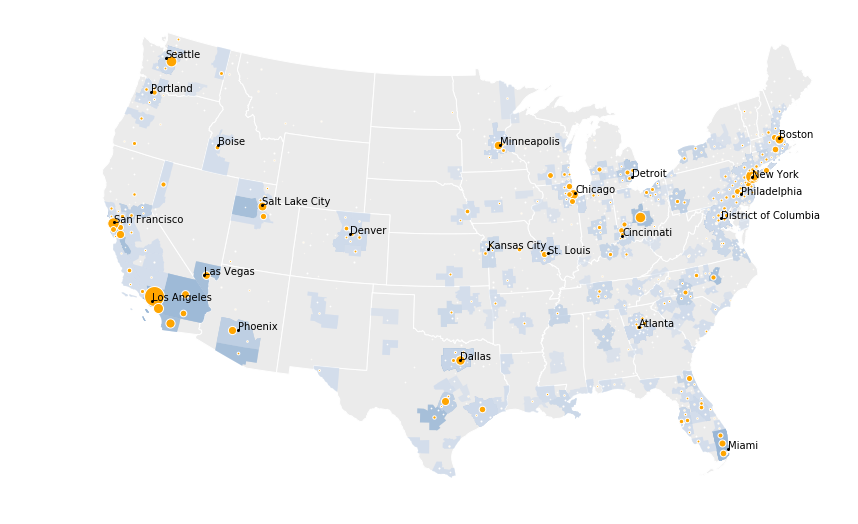

In [33]:
fig, amap = plt.subplots(1, 1, figsize = (14,12))
amap.set_aspect('equal')
amap.set_axis_off()
angle_rot = 75
center=(-98.5795,39.8283)


# State map of the continental US
us_cstate_df.to_crs(target_crs).rotate(angle=angle_rot, origin=center).plot(ax=amap,
                  zorder=1,
                  linewidth = 1,
                  facecolor="#EBEBEB",
                  edgecolor="white")

# Core base statistical areas with population > 1M
cbsa_pop_large_df.to_crs(target_crs).rotate(angle=angle_rot, origin=center).plot(ax=amap,
                  zorder=3,
                  linewidth=0,
                  alpha=0.6,                                                               
                  facecolor="#9AB7D6")

# Core base statistical areas with population > 250k and < 1M
cbsa_pop_medium_df.to_crs(target_crs).rotate(angle=angle_rot, origin=center).plot(ax=amap,
                  zorder=4,                                                                
                  linewidth=0,
                  alpha=0.6,                                                                
                  facecolor="#CFDBEB")

# Employment of ecommerce workers per point by county centroid 
# The spatial coordinates have already been projected to Albers equal area
# and rotated above .  This is so that we can use the matplotlib scatter function                           
for lon,lat,emp in zip(county_ecom_df['lon'],
                       county_ecom_df['lat'],
                       county_ecom_df['EMP']):
    amap.scatter(lon, lat, s=emp/40,
              zorder = 6,
              alpha=1.0,
              edgecolors="white",
              color='orange')
        
# City markers
points.to_crs(target_crs).rotate(angle=angle_rot, origin=center).plot(ax=amap,
                     zorder=8,
                     marker='o',
                     color='black',
                     markersize=4)

# City names
# The spatial coordinates have already been projected to Albers equal area
# and rotated above .  This is so that we can use the matplotlib text function 
for lon,lat,name in zip(cities_df.lon,
                        cities_df.lat,
                        cities_df.name):
    amap.text(lon, lat, name,
          fontsize=10, zorder=10)

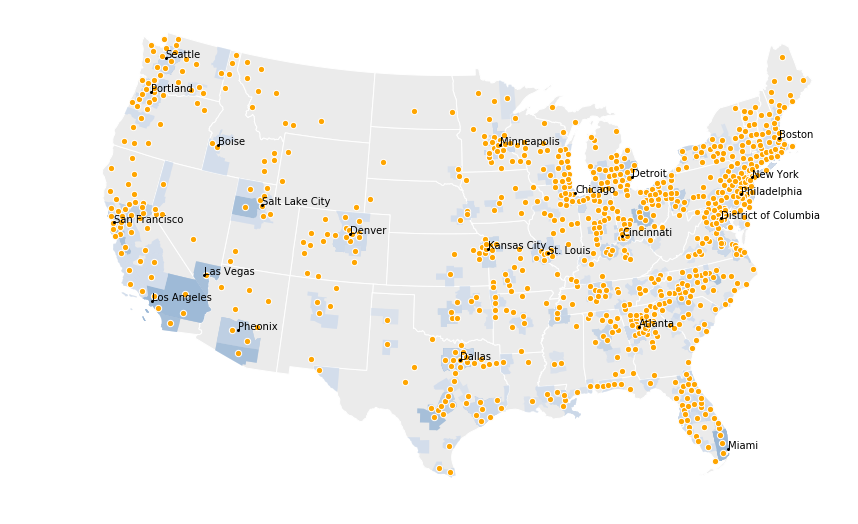

In [36]:
fig, amap = plt.subplots(1, 1, figsize = (14,12))
amap.set_aspect('equal')
amap.set_axis_off()
angle_rot = 75
center=(-98.5795,39.8283)


# State map of the continental US
us_cstate_df.to_crs(target_crs).rotate(angle=angle_rot, origin=center).plot(ax=amap,
                  zorder=1,
                  linewidth = 1,
                  facecolor="#EBEBEB",
                  edgecolor="white")

# Core base statistical areas with population > 1M
cbsa_pop_large_df.to_crs(target_crs).rotate(angle=angle_rot, origin=center).plot(ax=amap,
                  zorder=3,
                  linewidth=0,
                  alpha=0.6,                                                               
                  facecolor="#9AB7D6")

# Core base statistical areas with population > 250k and < 1M
cbsa_pop_medium_df.to_crs(target_crs).rotate(angle=angle_rot, origin=center).plot(ax=amap,
                  zorder=4,                                                                
                  linewidth=0,
                  alpha=0.6,                                                                
                  facecolor="#CFDBEB")

# Employment of ecommerce workers per point by county centroid 
# The spatial coordinates have already been projected to Albers equal area
# and rotated above .  This is so that we can use the matplotlib scatter function                           
for lon,lat,emp in zip(county_ecom_df['lon'],
                       county_ecom_df['lat'],
                       county_ecom_df['EMP']):
    amap.scatter(lon, lat, s=40,
              zorder = 6,
              alpha=1.0,
              edgecolors="white",
              color='orange')
        
# City markers
points.to_crs(target_crs).rotate(angle=angle_rot, origin=center).plot(ax=amap,
                     zorder=8,
                     marker='o',
                     color='black',
                     markersize=4)

# City names
# The spatial coordinates have already been projected to Albers equal area
# and rotated above .  This is so that we can use the matplotlib text function 
for lon,lat,name in zip(cities_df.lon,
                        cities_df.lat,
                        cities_df.name):
    amap.text(lon, lat, name,
          fontsize=10, zorder=10)